<a href="https://colab.research.google.com/github/Aleman778/Chatbot-Gamma/blob/master/notebooks/BabyBERTv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from tqdm import tqdm_notebook, tnrange
from __future__ import absolute_import, division, print_function, unicode_literals
import os.path
import sys
import math
import altair as alt
if 'transformers' not in sys.modules:
    !pip install altair==3.3.0  #Ver 4.0 broke updating plots without printing new ones.
    !pip uninstall -y transformers
    !pip install git+https://github.com/huggingface/transformers.git 
from transformers import *
if not os.path.isdir('/content/RAdam/'):
    !!git clone https://github.com/LiyuanLucasLiu/RAdam
sys.path.append('/content/RAdam')
from radam import RAdam
from transformers import AdamW, get_linear_schedule_with_warmup
import nltk

if not os.path.isfile('/content/amazon_cells_labelled.txt'):
    !!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19L-wTE6XFtEejYRfgpM2yUW4QIy3rCOY' -O 'amazon_cells_labelled.txt'

if not os.path.isfile('/content/responses.txt'):
    !!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yF95e1aB3EnBF540nDVeE8iU0Ee_rquh' -O 'responses.txt'

Uninstalling transformers-2.3.0:
  Successfully uninstalled transformers-2.3.0
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-38kuw8f6
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-38kuw8f6
  Created wheel for transformers: filename=transformers-2.3.0-cp36-none-any.whl size=458467 sha256=e6b200e03d775bb200781d1ff628d4d9c72ec7ecaedffebd9b8944246378861a
  Stored in directory: /tmp/pip-ephem-wheel-cache-imxn4tsu/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers


# 1 Preparation

---



## 1.1 Dataset and preprocessing

In [0]:
# Dataset class for amazon reviews, used for dataloader
class TextDataset(Dataset):    
    def __init__(self,data,data_label,tokenizer,max_length):
        self.max_length = max_length  # Max number of words used in sentence
        self.sentences = [] # List of sentences
        self.attention_masks = [] # List of attention masks
        self.labels = data_label 
        self.tokenizer = tokenizer

        for sentence in data:                                            
            sentence = tokenizer.encode(sentence, max_length=max_length) # encode = convert_to_ids(tokenize(sentence)), also adds [CLS] and [SEP], max_length arg truncates anything longer
            sentence = sentence + (max_length-len(sentence))*[tokenizer.pad_token_id] # Uses [PAD] for padding (from BERT tokenizer)
            self.sentences.append(sentence) 
            attn_mask = [1 if tokenid != tokenizer.pad_token_id else 0 for tokenid in sentence] # 1 real tokens, 0 for padding
            self.attention_masks.append(attn_mask)
            
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):     
        return torch.tensor(self.sentences[item]),torch.tensor(self.attention_masks[item]), self.labels[item] ##add .unsqueeze(0)?

# Preprocessing function - from canvas
def preprocess(filename):
    data = pd.read_csv(filename, delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                     
    columns = ['index', 'Class', 'Sentence']
    training_data, validation_data, training_labels, validation_labels = train_test_split( 
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.1,   #Train/Validation ratio
        random_state=0,
        shuffle=True)
    return training_data, validation_data, training_labels, validation_labels

   

## 1.2 Defining the model

In [0]:
class BertClassifier(nn.Module):
  def __init__(self, freeze_bert=True):
    super(BertClassifier, self).__init__()
    self.bert_layer = BertModel.from_pretrained('bert-large-uncased') # Loading Bert model?

    if freeze_bert:  # Freezing layers
      for param in self.bert_layer.parameters():
        param.requires_grad = False

    # Adding two layers after freezing
    self.linear = nn.Linear(1024, 1) 
    self.sigmoid = nn.Sigmoid()

  def forward(self, tokens, attention_mask):
    context_reps,_ = self.bert_layer(tokens, attention_mask=attention_mask)
    cls_reps = context_reps[:,0] 
    linear_output = self.linear(cls_reps)
    preds = self.sigmoid(linear_output)
    return preds

  def get_bert_outs(self,tokens,attention_mask):
    lhs,p_out = self.bert_layer(tokens,attention_mask=attention_mask)
    return lhs,p_out

## 1.3 Defining functions

In [0]:
# Training sequence
def train(model,train_loader,loss_function,optimizer,epoch):
    model.train()
    epoch_train_loss = 0
    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        prediction = model(input_ids,attention_mask)
        loss = loss_function(prediction.squeeze(-1), labels.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()*input_ids.size(0)
        print(f'\rEpoch: {epoch} Batch [{step+1}/{len(train_loader)}]\t Training loss: {round(loss.item(),3)}',
            end='')
    epoch_train_loss /= len(train_loader.dataset)
    return epoch_train_loss

# Validation sequence
def validate(model,validation_loader,loss_function,epoch):
    model.eval()
    epoch_val_loss = 0
    correct = 0
    with torch.no_grad():
        for step, batch in enumerate(validation_loader):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            prediction = model(input_ids,attention_mask)
            loss = loss_function(prediction.squeeze(-1), labels.float())
            epoch_val_loss += loss.item()*input_ids.size(0)
            for i, x in enumerate(prediction):
                if x.round() == labels[i]:
                    correct+=1
            print(f'\rEpoch: {epoch} Batch [{step+1}/{len(validation_loader)}]\t Validation loss: {round(loss.item(),3)}',
            end='')
    epoch_val_loss /= len(validation_loader.dataset)
    accuracy = correct/len(validation_loader.dataset)*100
    return epoch_val_loss, accuracy

# Early stopping
def early_stop(lowest_loss,current_loss,stop_counter,patience):
    stop = False
    checkpoint = True
    if current_loss > lowest_loss:
        stop_counter += 1
        checkpoint = False
    else:
        stop_counter = 0
    if stop_counter >= patience:
        stop = True
    return stop_counter,stop, checkpoint

# Save model 
def save_checkpoint(savepath, model, epoch, train_losses, val_losses,correct,stop_counter):
    torch.save({
            'epoch': epoch,
            'stop_counter':stop_counter,
            'correct': correct,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_losses': val_losses,
            'train_losses': train_losses}, savepath+"epoch_"+str(epoch)+"_accuracy_"+str(round(accuracy,2))+".pth")
    print (f'\nModel saved to: {savepath}')

# Load a checkpoint
def load_checkpoint(filename, model, optimizer,train_losses,val_losses,correct,stop_counter):
    start_epoch = 0
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch'] +1
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        val_losses = checkpoint['val_losses']
        correct = checkpoint['correct']
        stop_counter = checkpoint['stop_counter']
        train_losses = checkpoint['train_losses']
        print("Loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print(f'No checkpoint found at {filename}')

    return model, optimizer, start_epoch,train_losses,val_losses,correct,stop_counter

# Function for plotting at end of training
def make_plot(train_losses,val_losses,corrects,epochs):
  plt.figure(figsize=[7,7])
  plt.subplot(311)
  plt.plot(range(1,epochs+1),train_losses)
  plt.plot(range(1,epochs+1),val_losses)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Training loss','Validation loss'])
  plt.title('Training & Validation Losses')

  plt.subplot(312)
  plt.plot(range(1,epochs+1),correct)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Accuracy'])
  plt.title('Accuracy')

  plt.tight_layout()
  plt.show()

# Function for manual testing by input prompt
def test(get_bert_outs=False,prompt='Enter a test sentence\n'):
  sentence = input(prompt)
  tokenized = tokenizer.encode(sentence)
  tokenized = tokenized + (32-len(tokenized))*[tokenizer.pad_token_id]
  attention_mask = [1 if tokenid != tokenizer.pad_token_id else 0 for tokenid in tokenized]
  tokenized = torch.tensor(tokenized).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)

  if get_bert_outs:
    return model.get_bert_outs(tokenized.unsqueeze(0),attention_mask.unsqueeze(0))
  
  else:
    outputs = model(tokenized.unsqueeze(0),attention_mask.unsqueeze(0))
    return 'positive' if outputs.round().item() == 1 else 'negative'

def make_plot():
    index = [i for i in range(len(batch_stats))]
    stats_cache = np.array(stats) # 0=epoch + step, 1 = batch loss, 2 = valid_acc, 3 = train_acc, 4 = valid_loss

    # Reformat training data to Panda dataframes
    data_batch = pd.DataFrame({'Step': index,
                               'Loss': batch_stats,
                               'Legend': ['Batch Loss' for i in range(len(batch_stats))]})  
    data1 = pd.DataFrame({'Step': stats_cache[0:,0],
                          'acc': stats_cache[0:,4],
                          'Legend': ['Validation Loss' for i in range(len(stats_cache))]})           
    data2 = pd.DataFrame({'Step': stats_cache[0:,0],
                          'acc': stats_cache[0:,2],
                          'Legend': ['Validation Accuracy' for i in range(len(stats_cache))]})         
    data3 = pd.DataFrame({'Step': stats_cache[0:,0],
                          'acc': stats_cache[0:,3],
                          'Legend': ['Train Accuracy' for i in range(len(stats_cache))]})             
    stacked = pd.concat([data1, data2, data3], axis=0) 
    # Plot data with Altair 
    titel = '         Training progression               '+'Batch Size: '+str(batch_size) + '    Learn Rate: '+str(lr)+'      Warmup Steps : '+ str(num_warmup_steps)+ '      Model : ' +pretrained_weights
    chart1 = alt.Chart(data_batch,width=1000,height=400,title=titel).mark_line().encode( 
      alt.X('Step',scale=alt.Scale(zero=False)),
      alt.Y('Loss',scale=alt.Scale(zero=True)),
      color='Legend',
      opacity=alt.value(1), 
    ) 
    chart2 = alt.Chart(stacked,width=1000,height=400,title=titel,).mark_line().encode( 
      alt.X('Step',scale=alt.Scale(zero=False)),
      alt.Y('acc',scale=alt.Scale(zero=True)),
      color='Legend',
      opacity=alt.value(1), 
    )
    # Merge the two subplots
    super_chart = chart1 + chart2  
    super_chart.background ='#507a7a'  #google CCS color picker  #background='#788ba1', 6889bd
    super_chart= super_chart.configure_axis(
        gridOpacity=0.15,
    labelFontSize=20,
    titleFontSize=20
        ).configure_legend(
            labelFontSize=18,
            titleFontSize=21
        ).configure_title(fontSize=20                 
        ).interactive(bind_y=True
        ).configure_view(strokeOpacity =0)
    super_chart.display() 

# 2 Initializing

In [0]:
# Mount drive for model saving and loading, change 'mount' to True if gdrive not mounted
mount = False
if mount:
  from google.colab import drive
  drive.mount('/gdrive')

model = BertClassifier()
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased') # For testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

# Preprocess the data 
training_data,validation_data,training_labels,validation_labels = preprocess('amazon_cells_labelled.txt') 
# Create Textdataset objects for training and validation
training_ids = TextDataset(training_data,training_labels,tokenizer,32)
validation_ids = TextDataset(validation_data,validation_labels,tokenizer,32)

# 3 Training and validation

Training on: Tesla K80
Epoch: 1 Batch [7/7]	 Validation loss: 0.568
  Avg. Training loss = 0.5911 	Avg. Validation Loss = 0.527	 Accuracy = 94.0%

 **************************************************************************************************** 

Epoch: 2 Batch [7/7]	 Validation loss: 0.521
  Avg. Training loss = 0.5553 	Avg. Validation Loss = 0.5221	 Accuracy = 94.0%

 **************************************************************************************************** 

Epoch: 3 Batch [7/7]	 Validation loss: 0.528
  Avg. Training loss = 0.5431 	Avg. Validation Loss = 0.5222	 Accuracy = 94.0%

 **************************************************************************************************** 

Epoch: 4 Batch [7/7]	 Validation loss: 0.521
  Avg. Training loss = 0.5387 	Avg. Validation Loss = 0.5184	 Accuracy = 94.0%

 **************************************************************************************************** 

Epoch: 5 Batch [7/7]	 Validation loss: 0.511
  Avg. Training l

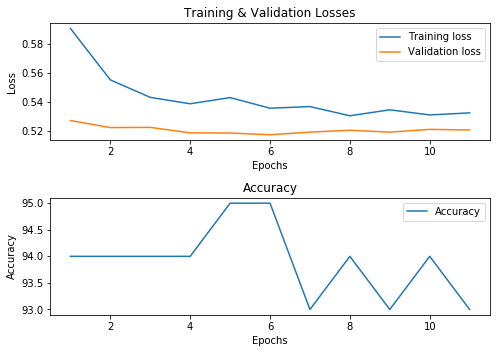

In [0]:
epochs = 15
patience = 5
LEARNING_RATE = 1e-2
BATCH_SIZE = 16
save = False
load = False
savepath = '/gdrive/My Drive/Colab Notebooks/checkpoints/'
filename = savepath+'modelepoch_4_accuracy_94.0.pth'

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.1,threshold=0.01,min_lr=1e-4,verbose=True)

# Create loaders for training and validation
train_loader = DataLoader(training_ids,batch_size=BATCH_SIZE)
validation_loader=DataLoader(validation_ids,batch_size=BATCH_SIZE)

# Setup lists for epoch stats
train_losses = []
val_losses = []
correct = []
batch_stats = []

stop = False
stop_counter = 0
start_epoch = 1

GPU = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU😢"
print("Training on:", GPU)

if load:
  model,optimizer,start_epoch,train_losses,val_losses,correct,stop_counter = load_checkpoint(filename,model,optimizer,train_losses,val_losses,correct,stop_counter)

start_time = time.time()
for epoch in range(start_epoch,epochs+1):
    
    current_train_loss = train(model,train_loader,criterion,optimizer,epoch)
    current_val_loss,accuracy = validate(model,validation_loader,criterion,epoch)
    scheduler.step(current_val_loss)
    print ('\n', f' Avg. Training loss = {round(current_train_loss,4)} \tAvg. Validation Loss = {round(current_val_loss,4)}\t Accuracy = {round(accuracy,3)}%')
    train_losses.append(current_train_loss)
    val_losses.append(current_val_loss)
    correct.append(accuracy)

    stop_counter,stop,checkpoint = early_stop(min(val_losses),current_val_loss,stop_counter,patience)
    
    if checkpoint & save: 
        save_checkpoint(savepath, model, epoch, train_losses, val_losses,correct,stop_counter)
    
    if stop == True:
        print ('\n', f'Early stop ! (Patience = {patience}) \nBest at epoch {epoch-patience}')
        break

    print ('\n','*****'*20,'\n')

time_elapsed = time.time() - start_time
print("Training completed in: {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

plt.figure(figsize=[7,7])
plt.subplot(311)
plt.plot(range(1,len(train_losses)+1),train_losses)
plt.plot(range(1,len(val_losses)+1),val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss','Validation loss'])
plt.title('Training & Validation Losses')

plt.subplot(312)
plt.plot(range(1,len(correct)+1),correct)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy'])
plt.title('Accuracy')

plt.tight_layout()
plt.show()

# 4 Testing

In [0]:
class Responses():
    def __init__(self,filename):
        # Load responses from textfile
        self.response_data=pd.read_csv(filename, delimiter='\t', header=None)
        self.response_data.columns = ['Response', 'Class']
        self.response_data['Index'] = self.response_data.index 
        
        self.pos_response = self.response_data.loc[self.response_data['Class']==1]
        self.neg_response = self.response_data.loc[self.response_data['Class']==0]
        self.prompts = self.response_data.loc[self.response_data['Class']==2]

    def prompt(self):
        # Pull a random prompt for user to respond to.   
        return np.random.choice(self.prompts['Response'])
    # Grab an appropriate response. 
    def get_response(self,review):
        if review=='positive':
            return np.random.choice(self.pos_response['Response'])
            #return self.pos_response.sample(1)['Response']
        else:
            return np.random.choice(self.neg_response['Response'])

In [0]:
def chat(response_file):
  while True:
    resp = Responses(response_file)
    prompt_text = resp.prompt()
    sentiment = test(prompt=prompt_text+'\n')
    print ('(Sentiment = ' + sentiment+')')
    print (resp.get_response(sentiment))
    cont = input('Continue? (y/n)\t')
    if cont == 'n':
      print ('Goodbye')
      break
    else:
      continue
  

In [0]:
#chat('/gdrive/My Drive/Colab Notebooks/responses_labelled2.txt')
chat('responses.txt')

Fact of the day: Bottled water expiration dates are for the bottle, not the water., What did you think about this fact?
Very interesting
(Sentiment = positive)
Great, you should buy more of the same item then.
Continue? (y/n)	y
Fact of the day: The inventor of the frisbee was turned into a frisbee after he died, What did you think about this fact?
Boring
(Sentiment = negative)
That makes me sad
Continue? (y/n)	n
Goodbye
